In [1]:
import os
import re
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

In [2]:
train_data = pd.read_csv('/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/train.csv')
train_data.head()

,unique Id,transcription
0,Rodrigo_00006_00,Historia De España_Del
1,Rodrigo_00006_01,Arçobispo. Do Rodri_
2,Rodrigo_00006_02,go. Traducida En Ro_
3,Rodrigo_00006_03,mançe
4,Rodrigo_00008_00,E ste es el libro de la Cronica de es


In [3]:
import numpy as np

def wer(reference, hypothesis):
    """
    Calculate the Word Error Rate (WER) between a reference and hypothesis sentence.
    WER is defined as the minimum number of word-level edits (insertions, deletions, substitutions)
    required to convert the hypothesis sentence into the reference sentence, divided by the total number of words in the reference.

    Parameters:
    reference (str): The ground truth sentence.
    hypothesis (str): The predicted sentence.

    Returns:
    float: The word error rate between the reference and hypothesis.
    """

    # Split the reference and hypothesis sentences into words
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()

    # Create a matrix to store the distances
    d = np.zeros((len(reference_words) + 1, len(hypothesis_words) + 1), dtype=np.uint8)

    # Initialize the matrix
    for i in range(1, len(reference_words) + 1):
        d[i][0] = i
    for j in range(1, len(hypothesis_words) + 1):
        d[0][j] = j

    # Fill the matrix
    for i in range(1, len(reference_words) + 1):
        for j in range(1, len(hypothesis_words) + 1):
            if reference_words[i - 1] == hypothesis_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                d[i][j] = min(d[i - 1][j], d[i][j - 1], d[i - 1][j - 1]) + 1

    # The WER is the number of errors divided by the total number of words in the reference sentence
    wer_value = d[len(reference_words)][len(hypothesis_words)] / len(reference_words)

    return wer_value

In [4]:
import os
from PIL import Image

test_img = []

# Function to sort the images by the numerical value after 'L_'
def sort_key(pth):
    # Extract the numeric part after 'L_' and convert it to an integer for proper sorting
    base_name = os.path.basename(pth)  # Get the file name
    num_part = base_name.split('_')[1].split('.')[0]  # Extract number part from 'L_1.png'
    return int(num_part)  # Convert to integer for sorting

# Iterate over each folder and get the images
for pth in sorted(os.listdir('/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/test_images')):
    page_path = os.path.join('/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/test_images', pth)
    # Sort images based on the numerical part of the file name
    for img_pth in sorted(os.listdir(page_path), key=sort_key):
        test_img.append(Image.open(os.path.join(page_path, img_pth)).convert('RGB'))

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, get_linear_schedule_with_warmup
from PIL import Image
import os
from tqdm import tqdm

# Load custom vocabulary
# {'à', 'ã', 'è', '̃', 'ẽ'}
# custom_vocab = 'eIṕ8EZOāLS6ī7Ⴒ1xsj-(ƚz=f|Dđyg,łl&)ę05o¶mFuXñ4déHȓšºQ_BJ pēa℣Tnc"t:ʠçք♦ś–wGū3i;rh+/ỹ₉óō?íUħáḡþAřbPR9vq2CÇ\\"YV.NM'

class HistoricalTextDataset(Dataset):
    def __init__(self, dataframe, img_dir, processor):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['unique Id']
        image = Image.open(os.path.join(self.img_dir, f"{img_name}.png")).convert("RGB")
        
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(self.dataframe.iloc[idx]['transcription'], 
                                          padding="max_length", 
                                          max_length=128).input_ids
        
        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}

In [6]:
class HistoricalTextDataset2(Dataset):
    def __init__(self, dataframe, img_dir, processor):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
#         img_name = f"L_{idx%24+1}"
        image = test_img[idx]
        
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(self.dataframe.iloc[idx]['transcription'], 
                                          padding="max_length", 
                                          max_length=128).input_ids
        
        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}

In [7]:
import pandas as pd
train_df = pd.read_csv('/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/train.csv')

original_text = ' '.join(list(train_df['transcription']))
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np

def add_noise(image, factor=0.02):
    img_array = np.array(image)
    noise = np.random.normal(0, 255 * factor, img_array.shape).astype(np.uint8)
    noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def apply_aging_effect(input_path, output_path):
    # Open the image
    img = Image.open(input_path).convert('RGB')
    
    # 1. Reduce contrast and increase brightness
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(0.9)  # Reduce contrast
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(1.1)  # Increase brightness slightly
    
#     # 2. Add noise
    img = add_noise(img)
    
#     # 3. Apply slight blur
    img = img.filter(ImageFilter.GaussianBlur(radius=1.1))
    
    img.save(output_path)
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Define the path to save images
output_dir = "/kaggle/working/new_images_new_new/"
os.makedirs(output_dir, exist_ok=True)

# Load the font
font_path = '/kaggle/input/new-image-tools/OnlineWebFonts_COM_b9b8e97a0058f523d8f0cac07d2d6cb3/1726 Real Espanola W01 Regular/1726 Real Espanola W01 Regular.ttf'  # Replace this with your font path
font_size = 29
font = ImageFont.truetype(font_path, size=font_size)

# Parameters for the image size
image_width = 527
image_height = 54

# Load the background image you used previously
background_image_path = '/kaggle/input/new-image-tools/WhatsApp Image 2024-10-17 at 19.23.37.jpeg'
background_image = Image.open(background_image_path).resize((image_width, image_height))

# Your long paragraph text
# original_text = "YOUR_LONG_PARAGRAPH_HERE"  # Replace this with your actual text

# Function to create an image with text
def create_text_image(text, img_path):
    # Open the background image again to ensure it stays the same for each image
    img = background_image.copy()
    draw = ImageDraw.Draw(img)
    
    # Add the text to the image
    (x, y) = (2, 3)
    color = 'rgb(0, 0, 0)'  # Black color
    draw.text((x, y), text, fill=color, font=font)
    
    # Save the image
    img.save(img_path)
    apply_aging_effect(img_path, img_path)

# Function to fit text into the image width
def get_fitting_text(text, font, max_width):
    draw = ImageDraw.Draw(Image.new('RGB', (1, 1)))  # Create a temporary image just for text measurement
    fitting_text = ""
    
    for char in text:
        test_text = fitting_text + char
        
        # Get bounding box of the text
        bbox = draw.textbbox((0, 0), test_text, font=font)
        text_width = bbox[2] - bbox[0]  # Calculate the width of the text
        
        if text_width <= max_width:
            fitting_text = test_text
        else:
            break
    
    return fitting_text

# Create sliding window of text for each image
data = []
index = 0
while index < len(original_text):
    remaining_text = original_text[index:]
    
    # Get the portion of text that fits in the image width
    window_text = get_fitting_text(remaining_text, font, image_width)
    
    # Generate image file path
    img_filename = f"text_image_{index}.png"
    img_path = os.path.join(output_dir, img_filename)
    
    # Create the image with the exact text that fits
    create_text_image(window_text, img_path)
    
    # Add the image path and text to the DataFrame list
    data.append({"image_path": img_path, "text": window_text})
    
    # Move the index forward by the length of the fitted text
    index += len(window_text)

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file (optional)
df.to_csv(os.path.join(output_dir, "image_text_dataset.csv"), index=False)

df.head()  # Display the first few rows of the dataframe

,image_path,text
0,/kaggle/working/new_images_new_new/text_image_...,Historia De España_Del Arçobispo. Do
1,/kaggle/working/new_images_new_new/text_image_...,Rodri_ go. Traducida En Ro_ mançe E s
2,/kaggle/working/new_images_new_new/text_image_...,te es el libro de la Cronica de es paña. Y
3,/kaggle/working/new_images_new_new/text_image_...,"cuenta, como fue poblada primeramente"
4,/kaggle/working/new_images_new_new/text_image_...,y co mo fue destruyda. & quien por este


In [8]:
import pandas as pd

# Load your train.csv file
train_df = pd.read_csv('/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/train.csv')

# Define the path where your images are stored
image_base_path = '/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/train_images/'

# Create a new column with the full image paths
train_df['image_path'] = image_base_path + train_df['unique Id'] + '.png'

# Renaming the 'transcription' column to 'text' to match the format
train_df = train_df.rename(columns={'transcription': 'text'})

# Now append this to your existing dataframe df
df = pd.concat([df, train_df[['image_path', 'text']]], ignore_index=True)

# Display the updated dataframe
df

,image_path,text
0,/kaggle/working/new_images_new_new/text_image_...,Historia De España_Del Arçobispo. Do
1,/kaggle/working/new_images_new_new/text_image_...,Rodri_ go. Traducida En Ro_ mançe E s
2,/kaggle/working/new_images_new_new/text_image_...,te es el libro de la Cronica de es paña. Y
3,/kaggle/working/new_images_new_new/text_image_...,"cuenta, como fue poblada primeramente"
4,/kaggle/working/new_images_new_new/text_image_...,y co mo fue destruyda. & quien por este
...,...,...
35739,/kaggle/input/ai-of-god-input/ai-of-god-3/Publ...,mes En zelo de la fe & partian lo que Auian a ...
35740,/kaggle/input/ai-of-god-input/ai-of-god-3/Publ...,an menester. & se parauan muy rezios En los pe...
35741,/kaggle/input/ai-of-god-input/ai-of-god-3/Publ...,suffrian mucho trabajo por amor de dios / del ...
35742,/kaggle/input/ai-of-god-input/ai-of-god-3/Publ...,"tilla estos prelados, don Rodrigo Arçobispo de..."


In [9]:
len(df)

35744

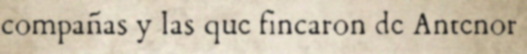

In [10]:
Image.open(df['image_path'].iloc[500])

In [11]:
class HistoricalTextDataset3(Dataset):
    def __init__(self, dataframe, img_dir, processor):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
#         img_name = f"L_{idx%24+1}"
        image = Image.open(self.dataframe['image_path'].iloc[idx]).convert("RGB")
        
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(self.dataframe.iloc[idx]['text'], 
                                          padding="max_length", 
                                          max_length=128).input_ids
        
        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}

In [12]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
from unidecode import unidecode

text_with_accents = "Señor, cuál es su dirección?"
text_without_accents = unidecode(text_with_accents)

print(text_without_accents)  # Output: "Senor, cual es su direccion?"

Senor, cual es su direccion?


In [14]:
def transcribe_image(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return unidecode(generated_text.replace("f","s"))

In [15]:
lss = []
weer =[]
tills = [len(df)]
num_epochss = [2]

In [16]:
# df['group'] = list(range(len(df)-250))+list(range(250))

In [17]:
# from sklearn.model_selection import GroupShuffleSplit

# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# X = df.drop(columns='group')
# groups = df['group']

# for train_idx, test_idx in gss.split(X, groups=groups):
#     train_df = df.iloc[train_idx]
#     val_df = df.iloc[test_idx]


In [18]:
# len(df)

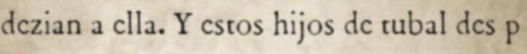

In [19]:
(Image.open(df.iloc[600,0]).convert("RGB"))

In [20]:
# from sklearn.model_selection import train_test_split
# train_df,test_df  = train_test_split(df,test_size

In [21]:
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.manual_seed(42)
for till,num_epochs in zip(tills,num_epochss):   
    import gc
    gc.collect()
    import torch
    torch.cuda.empty_cache()
    processor = TrOCRProcessor.from_pretrained("qantev/trocr-large-spanish")
    model = VisionEncoderDecoderModel.from_pretrained("qantev/trocr-large-spanish")
    # Freeze the first few layers of the encoder
    for layer in model.encoder.encoder.layer[:2]:  # Assuming it has multiple layers
        for param in layer.parameters():
            param.requires_grad=False
    import pickle
    with open('/kaggle/input/ai-of-god-answers/label.pkl','rb') as f:
        labels = pickle.load(f)
    additional_data = pd.DataFrame({'transcription':labels})
    train_dataset = HistoricalTextDataset3(train_df[:till], '/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/test_images/Page_1', processor)
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    import torch
    from torch.utils.data import DataLoader
    from transformers import get_linear_schedule_with_warmup
    from tqdm import tqdm

    # Assuming all the previous parts (imports, dataset, model initialization) remain the same

    # Set up the training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Disable autocast for the model
    model.float()  # Ensure the model is in float32

    # Enable mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-7)
    num_training_steps = len(train_dataloader) * 2  # 2 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    # Training loop
    accumulation_steps = 4  # Gradient accumulation

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for i, batch in enumerate(tqdm(train_dataloader)):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Disable autocast for forward pass
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()

            # Normalize loss to account for batch accumulation
            loss = loss / accumulation_steps

            # Scales loss and calls backward() to create scaled gradients
            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                # Unscales the gradients of optimizer's assigned params in-place
                scaler.unscale_(optimizer)

                # Clip gradients to prevent exploding gradients problem
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # optimizer.step and update learning rate
                scaler.step(optimizer)
                scheduler.step()

                # Updates the scale for next iteration
                scaler.update()

                optimizer.zero_grad()

            # Clear CUDA cache periodically
            if i % 100 == 0:
                torch.cuda.empty_cache()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    # Save the fine-tuned model
        model.save_pretrained(f"/kaggle/working/fine_tuned_trocr_model_custom_vocab_epoch_{epoch}")
        processor.save_pretrained(f"/kaggle/working/fine_tuned_trocr_processor_custom_vocab_epoch_{epoch}")
    lss.append(avg_loss)
    # Function to perform inference
    def transcribe_image(image_path):
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return generated_text
    with open('/kaggle/input/ai-of-god-answers/label.pkl','rb') as f:
        labels = pickle.load(f)

    wer_ = []
    j=0
    def natural_sort_key(s):
        return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]
    base_dir = '/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/test_images'
    submission_df = pd.read_excel("/kaggle/input/ai-of-god-input/ai-of-god-3/Public_data/submission.csv.xlsx")
    submission_data = []
    from tqdm import tqdm
    for folder in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder)
        page_number = folder.split('_')[-1]

        if os.path.isdir(folder_path):
            for image_file in tqdm(sorted(os.listdir(folder_path), key=natural_sort_key)):
                if image_file.endswith('.png'):  
                    image_path = os.path.join(folder_path, image_file)
                    line_number = image_file.split('_')[-1].split('.')[0]
                    formatted_image_id = f'P_{page_number}_L_{line_number}'
                    model.eval()

                    predicted_text = transcribe_image(image_path)
                    wer_.append(wer(labels[j],predicted_text))
                    
                    j+=1
                    submission_data.append(predicted_text)
    print(f"WER---------------------------{np.mean(wer_)}")
    submission_df['prediction'] = submission_data
    submission_df["unique Id"]=submission_df["unique id"]
    submission_df.drop("unique id",axis=1,inplace=True)
    pred=submission_df["prediction"]
    submission_df.drop("prediction",axis=1,inplace=True)
    submission_df["prediction"]=pred
    # submission_df['prediction'][:168]=complete_corrected_sentences
    submission_df.to_csv('submission.csv', index=False)
    weer.append(np.mean(wer_))
    print("submission file created successfully!")
    !head submission.csv

preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.97k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

/tmp/ipykernel_23/1388301147.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
100%|██████████| 7505/7505 [1:08:12<00:00,  1.83it/s]


Epoch 1/2, Average Loss: 0.3600


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
100%|██████████| 7505/7505 [1:08:11<00:00,  1.83it/s]


Epoch 2/2, Average Loss: 0.0570


  0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 24/24 [00:07<00:00,  3.16it/s]
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


WER---------------------------0.2593986205593349
submission file created successfully!
unique Id,prediction
P_1_L_1,ero deñor por fus rectifsimos y ocul
P_1_L_2,"cos juyzios de darme ciempo, para"
P_1_L_3,que en vueltra educacion lo mani
P_1_L_4,"tellalle, pues me hallo tantos mefes"
P_1_L_5,"ha rendida en efta cama, à vna en"
P_1_L_6,"ternedad cal, que de de fu princi"
P_1_L_7,"pio me amenaza con la muerte, y"
P_1_L_8,"vuelta orfandad en tiernos años,"
P_1_L_9,ali pues como os di al mundo con


In [22]:
# lss,tills,num_epochss,weer

In [23]:
# try:
#     experiments = pd.DataFrame({'Loss':lss,'number of images':tills,'num_epochs':num_epochss,'wer':weer})
#     print(experiments)
#     output = experiments.to_csv('experiments.csv')
# except:
#     print("hehe")

In [24]:
# 0.295 -> 2 thok aadhe pe | 12.5
# 0.292 -> 1 thok aadhe pe | 15
# 0.297 -> 1 thok pure pe | 13
# 0.294 -> 1 thok 1 page pe | 10
# 0.294 -> 2 thok 1 page pe | 9.3
# 0.288 -> 1 image 1 thok | 17.2 
# 0.288 -> 1 image 10 thok | 18.169


In [25]:
# sub = pd.read_csv('/kaggle/input/subbbb/submission (2).csv')
# sub

In [26]:
# y_pred = sub['prediction']